In [ ]:
!pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install flax

In [2]:
# imports

import jax
from jax import random
import jax.numpy as jnp
from flax import linen as nn
from flax.linen import initializers
import numpy as np
from flax.training.common_utils import shard, get_metrics
import optax
import math

#jax.config.update("jax_enable_x64", False)


In [3]:
# LRU layer definition

parallel_scan = jax.lax.associative_scan

class LRU(nn.Module):
    """Linear Recurrent Unit (LRU) layer"""
    state_dim:int
    embed_dim:int
    r_min: float = 0.5
    r_max: float = 0.99
    max_phase: float = 6.28
    dtype: type = jnp.bfloat16

    def setup(self):

        # weights
        self.B_re = self.param('B_re', initializers.glorot_normal(dtype=self.dtype), (self.state_dim, self.embed_dim))
        self.B_im = self.param('B_im', initializers.glorot_normal(dtype=self.dtype), (self.state_dim, self.embed_dim))
        self.C_re = self.param('C_re', initializers.glorot_normal(dtype=self.dtype), (self.embed_dim, self.state_dim))
        self.C_im = self.param('C_im', initializers.glorot_normal(dtype=self.dtype), (self.embed_dim, self.state_dim))
        self.D = self.param('D', initializers.normal(dtype=self.dtype), (self.embed_dim,))
        
        u1 = np.random.uniform(size=(self.state_dim,))
        u2 = np.random.uniform(size=(self.state_dim,))
        nu_log = np.log(-0.5*np.log(u1*(self.r_max**2-self.r_min**2) + self.r_min**2))
        theta_log = np.log(self.max_phase*u2).astype(self.dtype)
        
        diag_lambda = np.exp(-jnp.exp(nu_log) + 1j*jnp.exp(theta_log))
        gamma_log = np.log(jnp.sqrt(1-jnp.abs(diag_lambda)**2))

        # Initialize the parameters here
        self.nu_log = self.param('nu_log', lambda rng, shape: nu_log, ())
        self.theta_log = self.param('theta_log', lambda rng, shape: theta_log, ())
        self.gamma_log = self.param('gamma_log', lambda rng, shape: gamma_log, ())

    def __call__(self, input_sequence):
        """Forward pass of the LRU layer. Output y and input_sequence are of shape (L, H)."""

        # Materializing the diagonal of Lambda and projections
        Lambda = jnp.exp(-jnp.exp(self.nu_log) + 1j*jnp.exp(self.theta_log))
        B_norm = (self.B_re + 1j*self.B_im) * jnp.expand_dims(jnp.exp(self.gamma_log), axis=-1)
        C = self.C_re + 1j*self.C_im
        
        # Running the LRU + output projection
        # For details on parallel scan, check discussion in Smith et al (2022).
        Lambda_elements = jnp.repeat(Lambda[None, None, :], input_sequence.shape[0], axis=0)
        Lambda_elements = jnp.repeat(Lambda_elements, input_sequence.shape[1], axis=1)

        Bu_elements = jax.vmap(jax.vmap(lambda u: B_norm @ u))(input_sequence)

        elements = (Lambda_elements, Bu_elements)
        _, inner_states = parallel_scan(self.binary_operator_diag, elements, axis=1) # all x_k
        y = jax.vmap(jax.vmap(lambda x, u: (C @ x).real + self.D * u))(inner_states, input_sequence)

        return y
    
    def binary_operator_diag(self, element_i, element_j):

        # Binary operator for parallel scan of linear recurrence.
        a_i, bu_i = element_i
        a_j, bu_j = element_j

        return a_j * a_i, a_j * bu_i + bu_j

In [4]:
class FFW(nn.Module):
    embed_dim: int
    FFW_dim: int
    dtype: type = jnp.bfloat16

    def setup(self):
        # Xavier (Glorot) initialization
        up_kernel_init = nn.initializers.xavier_uniform()
        down_kernel_init = nn.initializers.xavier_uniform()

        self.up = nn.Dense(self.FFW_dim, use_bias=False, kernel_init=up_kernel_init, dtype=self.dtype)
        self.down = nn.Dense(self.embed_dim, use_bias=False, kernel_init=down_kernel_init, dtype=self.dtype)    
            
    def __call__(self, x):
        x = self.up(x)
        x = nn.activation.silu(x)
        x = self.down(x)
        return x
    

In [5]:
class LRU_block(nn.Module):
    embed_dim: int
    FFW_dim: int
    state_dim: int
    r_min: float = 0.5
    r_max: float = 0.99
    max_phase: float = 6.28
    dtype: type = jnp.bfloat16

    def setup(self):
        self.ffw = FFW(embed_dim=self.embed_dim, FFW_dim=self.FFW_dim, dtype=self.dtype)
        self.lru = LRU(embed_dim=self.embed_dim, state_dim=self.state_dim, r_min=self.r_min, r_max=self.r_max, max_phase=self.max_phase, dtype=self.dtype)
        self.norm1 = nn.LayerNorm(dtype=self.dtype)
        self.norm2 = nn.LayerNorm(dtype=self.dtype)

    def __call__(self, x):
        x = self.norm2(x)
        x = x + self.lru(x)
        
        x = self.norm1(x)
        x = x + self.ffw(x)

        return x

In [6]:
class LRU_LLM(nn.Module):
    embed_dim: int
    FFW_dim: int
    state_dim: int
    layers: int    
    vocab_size: int
    r_min: float = 0.5
    r_max: float = 0.99
    max_phase: float = 6.28
    dtype: type = jnp.bfloat16
    tie_weights: bool = True


    def setup(self):
        self.embed = nn.Embed(features=self.embed_dim, num_embeddings=self.vocab_size, dtype=self.dtype)
        self.blocks = [LRU_block(embed_dim=self.embed_dim, FFW_dim=self.FFW_dim, state_dim=self.state_dim, r_min=self.r_min, r_max=self.r_max, max_phase=self.max_phase, dtype=self.dtype) for _ in range(self.layers)]
        self.final_norm = nn.LayerNorm(dtype=self.dtype)

        
        if not self.tie_weights:
            self.unembed = nn.Dense(self.vocab_size, dtype=self.dtype) # if not weight tied

    def __call__(self, x):

        # x = jax.nn.one_hot(x, num_classes=self.vocab_size, dtype=self.dtype)

        # embed tokens
        x = self.embed(x)

        # pass through all LRU blocks
        for block in self.blocks:
            x = block(x)

        # final ln
        x = self.final_norm(x)

        if self.tie_weights:
            logits = self.embed.attend(x)
        else:
            logits = self.unembed(x)

        # softmax projection
        return logits


In [7]:
# load dataset

path_to_dataset_txt = 

chars = list(set(open(path_to_dataset_txt).read()))
chars.insert(0, '</s>')
chars.insert(0, '<s>')
chars.insert(0, '<unk>')

dataset_samples = open(path_to_dataset_txt).read().split('<|endoftext|>')

print(len(dataset_samples))
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for i, ch in enumerate(chars)}



607283


In [ ]:
# --- Tokenizer and Data loading
import torch

# --- pretrained subword tokenizer from Llama2
class Llama2_Tokenizer():
    !pip install tokenizers==0.13.3
    !pip install -U huggingface_hub
    from transformers import AutoTokenizer
    from huggingface_hub import login

    login()
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
    tokenizer.pad_token = tokenizer.eos_token

    vocab_size =  32000

    def tokenize(self, text, max_length=None):
        llamaencoded = self.tokenizer.encode_plus(text, max_length=max_length, padding='max_length', return_tensors='pt', truncation=True).input_ids[0].tolist()
        if max_length is None:
            llamaencoded.append(2)

        return llamaencoded
    

    def detokenize(self, text):
        return self.tokenizer.decode(torch.tensor(text))

# --- character-level tokenizer
class Char_Tokenizer():
    def __init__(self):
        global vocab_size
        vocab_size = len(chars)
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)

    def tokenize(self, text, max_length=None):
        list = [char2idx[ch] for ch in text]
        list.insert(0,1)
        list.append(2)
        if max_length is None:
            return list
        else: # padding/cropping if max length is specified
            list += [2 for i in range(max(0,max_length-len(list)))]
            list = list[0:max_length]
            return list
    
    def detokenize(self, ids):
        return "".join([self.idx2char[i] for i in ids])







# --- Data loader
class SimpleDataLoader:
    def __init__(self, dataset_samples, batch_size, context_length, tokenizer):
        self.context_length=context_length
        self.dataset_samples = dataset_samples
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.batch_size = batch_size
        self.vocab_size = len(char2idx)
        self.tokenizer=tokenizer

    def __len__(self):
        return len(self.dataset_samples)

    def get_batch(self, index):
        batch_samples = self.dataset_samples[index : index + self.batch_size]
        batch_input = []
        batch_target = []
        for sample in batch_samples:
            input_ids = self.tokenizer.tokenize(sample, max_length=self.context_length)
            batch_input.append(input_ids[:-1]) # BOS,1,2,3,4,...
            batch_target.append(input_ids[1:]) # 1,2,3,4,...EOS
        return jnp.array(batch_input), jnp.array(batch_target)

    


In [9]:
# -------- HYPERPARAMETERS

ctx_size = 256
embed_dim = 1024
FFW_dim = embed_dim*3
state_dim = 512
layers = 2
batch_size = 8
lr = 5e-5
iterations = 10000

# --- whether to use character level tokenizer or Llama-2 tokenizer
# tokenizer = Char_Tokenizer()
tokenizer = Llama2_Tokenizer()
vocab_size = tokenizer.vocab_size

key1 = random.PRNGKey(0) # generate random vector for reproducability

x = jnp.ones(shape=(1,512), dtype=jnp.int32)
lru_LLM = LRU_LLM(embed_dim=embed_dim, FFW_dim=FFW_dim, state_dim=state_dim, layers=layers, vocab_size=math.ceil(vocab_size/16)*16, r_min=0.5, r_max=0.9, max_phase=2*math.pi, dtype=jnp.bfloat16) # LRU hyperparameters from LRU paper
lru_LLM_params = lru_LLM.init(key1, x)

2023-10-03 22:37:52.484265: W external/xla/xla/service/gpu/nvptx_compiler.cc:596] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.140). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [10]:
# --- autoregressive generative inference
from transformers import top_k_top_p_filtering

def predictions(tokens, model, params, wanted_index=-1, temp=0.3):
    
    # Perform a forward pass through the model
    input_ids = jnp.array([tokens])
    logits = model.apply(params, input_ids)

    # greedy decoding
    if False:
        # Sample the next token from the logits
        #next_token_id = jax.random.categorical(logits=logits[0,-1][0:217], key=random.PRNGKey(0)).item()
        tokens = np.argmax(logits[0,:,0:vocab_size],axis=-1) # get most recent token
        print(tokens)
        return tokens

    # nucleus sampling
    else:
        logits = torch.tensor(np.asarray(logits.astype(jnp.float32)))[:,wanted_index,0:vocab_size]
        filtered_logits = top_k_top_p_filtering(logits, top_p=temp)
        probabilities = torch.nn.functional.softmax(filtered_logits, dim=-1)
        predicted_token = torch.multinomial(probabilities, 1)
        return predicted_token


    

# instead of iteratively predicting the next token then concatenating
# it to contect then predicting for contiually increasing sizes (which induces compilation for each new input size, which is very slow)
# just extend the context to the final target generation size, padding with </s>
def generate(model, params, gen_length, prompt='', temp=0.2): 
    """
    Generates text using the LRU_LLM language model.
    
    Args:
        model: LRU_LLM model instance.
        seed: Initial seed text to start generation.
        max_length: Maximum length of the generated text.
    
    Returns:
        Generated text as a string.
    """

    # tokenize input text    
    generated_text = prompt
    tokens = tokenizer.tokenize(generated_text, max_length=gen_length)
    padding_free = tokenizer.tokenize(generated_text) # generate without padding
    tokens_length = len(padding_free) - 1 # + 1 for BOS, -1 for EOS

    # get next token prediction for all tokens, including padding.
    # Set the first </s> in context to the predicted next token, then iterate.
    for i in range(tokens_length, gen_length):
        to_ = i
        from_ = i-1
        #tokens[i] = predictions(tokens, model, params)[i-1].item()
        predicted_token = predictions(tokens, model, params, wanted_index=from_, temp=temp).item()
        tokens[to_] = predicted_token

    generated_text = tokenizer.detokenize(tokens)

    return generated_text

In [11]:
print(generate(model=lru_LLM, params=lru_LLM_params, prompt='', gen_length=32, temp=0.2))

# with a small amount of layers, considering weight tying and skip connections and how LRU is initialized near identity, an initialized LRU-LLM will repeat the input.

# generation is very slow.

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>


In [12]:
from flax.training import train_state

data_loader = SimpleDataLoader(dataset_samples, batch_size=batch_size, context_length=ctx_size, tokenizer=tokenizer)

# During training, make sample generations. We can add a prompt to this.
prompt = '-<\{QUESTION\}>-\n\nPython 3.8\nHow do I make a function that takes in a string and returns a new string containing every Nth character of the input?'
prompt = ''
# nucleus sampling temperature to use for generation during training
temp = 0.3

# Model and optimizer
schedule = optax.cosine_decay_schedule(init_value=lr, decay_steps=iterations)
optimizer = optax.adam(learning_rate=schedule)
state = train_state.TrainState.create(apply_fn=lru_LLM.apply, params=lru_LLM_params['params'], tx=optimizer)

gen_frequency = 500

# Training loop
losses = []
accs = []
for epoch in range(1):

    for step in range(iterations):

        # get batch data
        xs, ys = data_loader.get_batch(step * batch_size)

        def loss_func(params):
            #get logits
            logits = state.apply_fn({'params': params}, xs)
            # get loss
            loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=ys).mean()
            return loss, logits
                
        gradient_fn = jax.value_and_grad(loss_func, has_aux=True)
        (loss, logits), grads = gradient_fn(state.params)

        acc = (logits.argmax(axis=-1) == ys).mean()
        losses.append(loss.item())
        accs.append(acc.item())
        # print(loss, acc)

        # step parameters
        state = state.apply_gradients(grads=grads)


        if step%gen_frequency == 0:
            print("\n\n\n")
            if step>0:
                print(step, 'loss:', np.asarray(losses[-gen_frequency:]).mean())
            else:
                print(step, 'loss:', losses[-1])
            
            # mostly for debugging - feeds the LLM an input sample, gets the top prediction for each token. 
            # NOTE: Since LRU is initizliaed near identity, if using weight tying and small number of layers, 
            # at initialization we will simply see it repeat the input, so it will look like its outputting perfectly coherent text, correctly predicting every token,
            # but its actually shifted by 1 compared to ground truth - its just outputting the most recent token :)
            #
            # print(" ======= DECODED:")
            # print(tokenizer.detokenize(logits[0,:,0:vocab_size].argmax(axis=-1)[:].tolist()))
            
            print("================= GENERATED =================")
            print(generate(lru_LLM, params={'params':state.params}, prompt=prompt, gen_length=ctx_size, temp=temp))






0 loss: 10.8125
================= GENERATED =================
<s><s><s><s><s><s><s>goinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoinggoing陳 \({\ \({\ \({\ \({\jpgjpgjpgjpgjpgjpgjpg.~.~.~.~czy José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José José

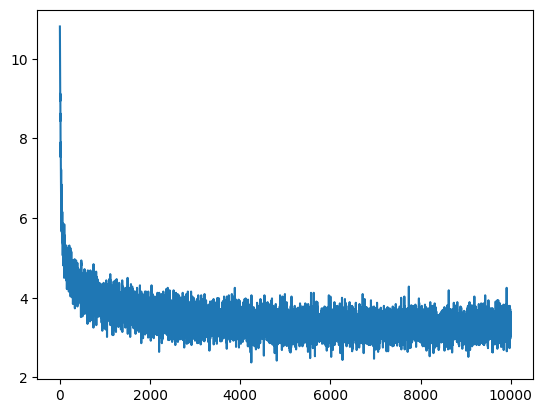

In [13]:
import matplotlib.pyplot as plt
plt.plot(losses)